In [2]:
# Load necessary modules

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from jupyterthemes import jtplot
import seaborn as sns
import random

import matplotlib.patches as patches

from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Cropping2D
from keras.layers import UpSampling2D
from keras.layers import Concatenate
from keras.layers import Input
from keras.models import Model
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [3]:
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline
jtplot.reset()
sns.set()

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 100

## 2. Getting Started

In [26]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3).reshape((1,-1))
        V = np.random.random(3).reshape((1,-1))
        
        ##vertices should be sorted by increasing x in order to improve the regression 6. outcomes
        vertices = np.concatenate((U,V),axis=0)
        vertices = vertices[:,vertices[0,:].argsort()]
        U = vertices[0]
        V = vertices[1]
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

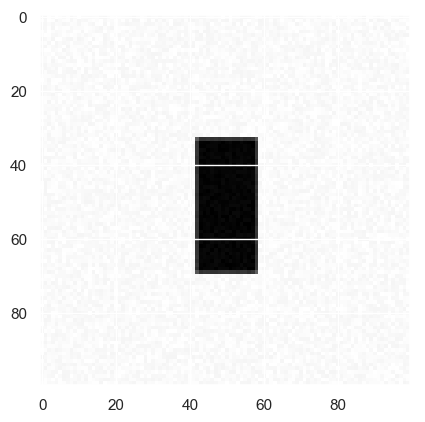

In [5]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

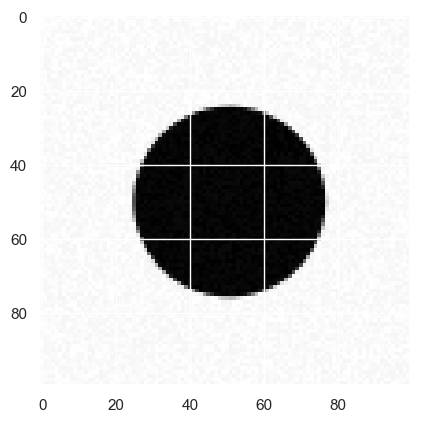

In [6]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

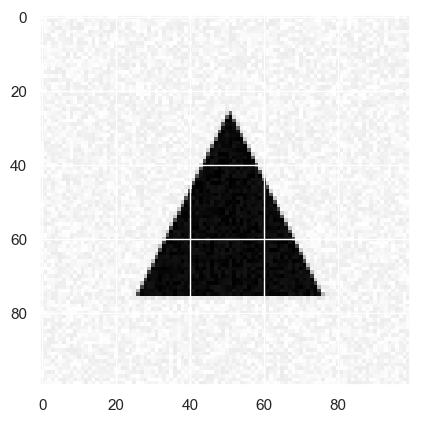

In [7]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

In [8]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1:
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3)
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

## 3. Simple Classification

Description: 
I will performe 2 classifications using 2 different optimizers: SGD and Adam.
In both cases, it is required to convert the Y_train in a matrix with as many columns as classes and the relevant loss function for classification is the categorical_crossentropy.
As the dataset is relatively small (300 images), I will use epochs=10 to train the classifiers. At last, I will use a softmax activation function to get separate probability for each of the 3 classes, and the probabilities will all add up to 1.

SEE CONCLUSION AT THE END OF THE PART 'SIMPLE CLASSIFICATION'

In [14]:
# generate a set of train data
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [ ]:
# Stochastic Gradient Descent otpimizer

In [15]:
# convert Y_train in a matrix with as many columns as there are classes (3 classes)
Y_train = to_categorical(Y_train)


In [16]:
# configure the first classification model
n_cols = X_train.shape[1]
model_sgd = Sequential()
model_sgd.add(Dense(3,activation='softmax', input_shape = (n_cols,)))

In [17]:
# configure the learning process with Stochastic Gradient Descent
model_sgd.compile(loss='categorical_crossentropy', optimizer='sgd')

In [18]:
# fit the model
model_sgd.fit(X_train, Y_train, batch_size=32, epochs=10)

Epoch 1/10
300/300 [==============================] - 1s 4ms/step - loss: 8.2568
Epoch 2/10
300/300 [==============================] - 0s 239us/step - loss: 10.3693
Epoch 3/10
300/300 [==============================] - 0s 212us/step - loss: 10.3693
Epoch 4/10
300/300 [==============================] - 0s 242us/step - loss: 10.3693
Epoch 5/10
300/300 [==============================] - 0s 205us/step - loss: 10.3693
Epoch 6/10
300/300 [==============================] - 0s 204us/step - loss: 10.3693
Epoch 7/10
300/300 [==============================] - 0s 200us/step - loss: 10.3693
Epoch 8/10
300/300 [==============================] - 0s 204us/step - loss: 10.3693
Epoch 9/10
300/300 [==============================] - 0s 190us/step - loss: 10.3693
Epoch 10/10
300/300 [==============================] - 0s 182us/step - loss: 10.3693


In [19]:
# Adam optimizer

In [20]:
# configure input shape for a model of 3 classes and one layer
n_cols = X_train.shape[1]
model_adam = Sequential()
model_adam.add(Dense(3,activation='softmax', input_shape = (n_cols,)))

In [23]:
# configure the learning process with Adam optimizer
model_adam.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [24]:
# fit the model
model_adam.fit(X_train, Y_train, batch_size=32, epochs=10)

Epoch 1/10
300/300 [==============================] - 1s 4ms/step - loss: 1.3668 - acc: 0.6600
Epoch 2/10
300/300 [==============================] - 0s 374us/step - loss: 0.2445 - acc: 0.9200
Epoch 3/10
300/300 [==============================] - 0s 296us/step - loss: 0.1192 - acc: 0.9767
Epoch 4/10
300/300 [==============================] - 0s 276us/step - loss: 0.0986 - acc: 0.9967
Epoch 5/10
300/300 [==============================] - 0s 250us/step - loss: 0.0777 - acc: 0.9967
Epoch 6/10
300/300 [==============================] - 0s 252us/step - loss: 0.0722 - acc: 1.0000
Epoch 7/10
300/300 [==============================] - 0s 262us/step - loss: 0.0718 - acc: 0.9967
Epoch 8/10
300/300 [==============================] - 0s 250us/step - loss: 0.0636 - acc: 0.9967
Epoch 9/10
300/300 [==============================] - 0s 260us/step - loss: 0.0562 - acc: 1.0000
Epoch 10/10
300/300 [==============================] - 0s 247us/step - loss: 0.0580 - acc: 1.0000


In [25]:
# Test a prediction 
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model_adam.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

Conclusion:
The Adam optimizer seems to outperform the Stochastic Gradient Descent in this case. We can see that the model with Adam optimizer manages to correctly classify a disk.

## 4. Visualization of the solution

In [76]:
# stochastic gradient descent weights
layer_weights_sgd = model_sgd.get_weights()[0]

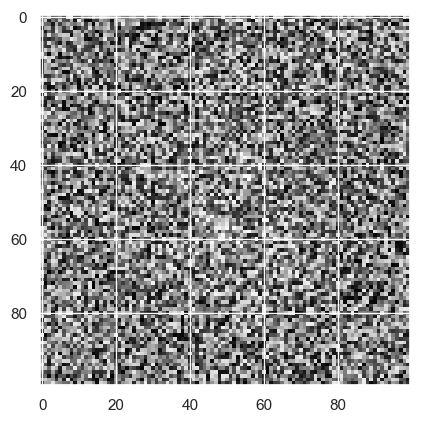

In [77]:
# image weights SGD column 1
plt.imshow(layer_weights_sgd[:,0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

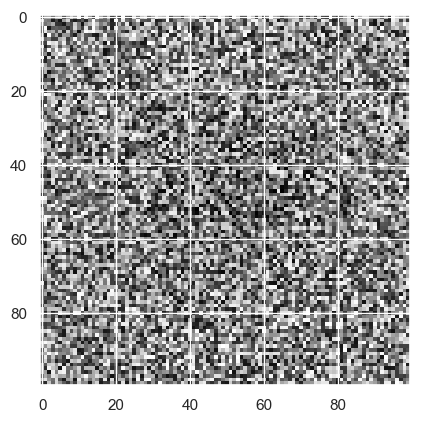

In [78]:
# image weights SGD column 2
plt.imshow(layer_weights_sgd[:,1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

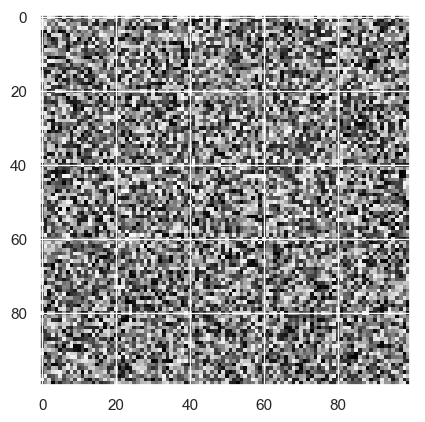

In [79]:
# image weights SGD column 3
plt.imshow(layer_weights_sgd[:,2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [80]:
# Adam weights
layer_weights_adam = model_adam.get_weights()[0]

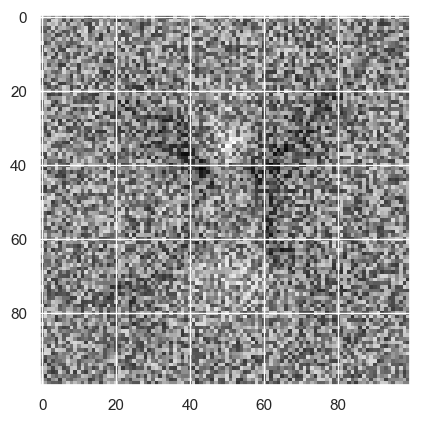

In [81]:
# image weights column 1
plt.imshow(layer_weights_adam[:,0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

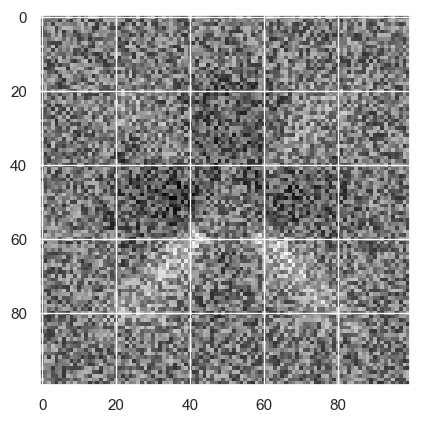

In [82]:
# image weights column 2
plt.imshow(layer_weights_adam[:,1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

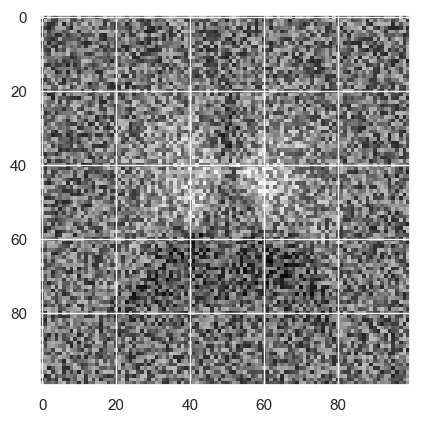

In [83]:
# image weights column 3
plt.imshow(layer_weights_adam[:,2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

Conclusion:
For SGD optimizer, we can barely distinguish a form in the image. Yet, a form can be distinguished when using Adam classifier. It managed to extract relrevant patterns (through its weights) to classify the input.

## 5. A more difficult classification problem

Description:

We will re-train the previous model (with Adam optimizer) with the new dataset (in which the forms can move within the image). We will use the accuracy information to have insight on the capacity of our model to classify.

After that, we will train a first convolutional network to handle this new classification with moving forms task. For this task, we will use a convolutional layer with 16 nodes and a kernel size of 5. 
It is also important to use a Maxpooling layer to reduce the number of parameters within the model and generalise the results.
I will flatten the result to be able to use a dense layer. 
At the end, I will add a dense layer with 3 nodes for the 3 possible classes.

The idea is to show that the convolutional network model will outperform the simple adam optimizer model

SEE CONCLUSION AT THE END OF THE PARTY "A MORE DIFFICULT CLASSIFICATION"

In [37]:
# Generate the new train dataset
[X_train_new, Y_train_new] = generate_dataset_classification(3000, 20, True)


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

In [38]:
# convert Y_train_new to a matrix with as many columns as there are classes (3 classes)
Y_train_new = to_categorical(Y_train_new)

In [39]:
# Retrain the Adam Linear Classifier with new dataset
n_cols_new = X_train_new.shape[1]
model_adam_new = Sequential()
model_adam_new.add(Dense(3,activation='softmax', input_shape = (n_cols_new,)))

In [40]:
# configure the Adam learning process with new dataset
model_adam_new.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
# fit the new model
model_adam_new.fit(X_train_new, Y_train_new, batch_size=32, epochs=10)

Epoch 1/10
3000/3000 [==============================] - 2s 781us/step - loss: 1.2800 - acc: 0.4593
Epoch 2/10
3000/3000 [==============================] - 1s 246us/step - loss: 0.9569 - acc: 0.5603
Epoch 3/10
3000/3000 [==============================] - 1s 247us/step - loss: 1.0805 - acc: 0.5600
Epoch 4/10
3000/3000 [==============================] - 1s 241us/step - loss: 1.0264 - acc: 0.5620
Epoch 5/10
3000/3000 [==============================] - 1s 357us/step - loss: 1.0403 - acc: 0.5730
Epoch 6/10
3000/3000 [==============================] - 1s 312us/step - loss: 1.0516 - acc: 0.5803
Epoch 7/10
3000/3000 [==============================] - 1s 331us/step - loss: 0.9915 - acc: 0.5760
Epoch 8/10
3000/3000 [==============================] - 1s 298us/step - loss: 0.9657 - acc: 0.5920
Epoch 9/10
3000/3000 [==============================] - 1s 264us/step - loss: 0.9490 - acc: 0.6237
Epoch 10/10
3000/3000 [==============================] - 1s 267us/step - loss: 0.8455 - acc: 0.6240


In [27]:
# Generate a test set
[X_test_new, Y_test_new] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [42]:
# Evaluate the Adam model
model_adam_new.evaluate(X_test_new, Y_test_new)

300/300 [==============================] - 0s 1ms/step


[0.9147713041305542, 0.5866666668653489]

In [43]:
# Train a convolutional (not-to-)deep network
model_conv = Sequential()
model_conv.add(Conv2D(16,kernel_size=5,activation='relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE,1)))
model_conv.add(MaxPooling2D(2))
model_conv.add(Flatten())
model_conv.add(Dense(100,activation='relu'))
model_conv.add(Dense(3,activation='softmax'))

In [44]:
# get the number of samples
n_rows_new = X_train_new.shape[0]
# reshape the input for convolution layer
X_train_conv = X_train_new.reshape(n_rows_new,IMAGE_SIZE,IMAGE_SIZE,1)


In [45]:
# Compile the convolutional (not-to-)deep network
model_conv.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [46]:
# Fit the convolutional (not-to-)deep network
EarlyStopping_monitor = EarlyStopping(patience=3) 
model_conv.fit(X_train_conv, Y_train_new, batch_size=32, epochs=50,callbacks=[EarlyStopping_monitor])

Epoch 1/50
3000/3000 [==============================] - 29s 10ms/step - loss: 1.3257 - acc: 0.5760
Epoch 2/50


/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


3000/3000 [==============================] - 28s 9ms/step - loss: 0.5962 - acc: 0.7443
Epoch 3/50
3000/3000 [==============================] - 25s 8ms/step - loss: 0.4868 - acc: 0.7913
Epoch 4/50
3000/3000 [==============================] - 24s 8ms/step - loss: 0.3806 - acc: 0.8613
Epoch 5/50
3000/3000 [==============================] - 23s 8ms/step - loss: 0.2955 - acc: 0.8950
Epoch 6/50
3000/3000 [==============================] - 22s 7ms/step - loss: 0.2736 - acc: 0.8960
Epoch 7/50
3000/3000 [==============================] - 24s 8ms/step - loss: 0.2082 - acc: 0.9200
Epoch 8/50
3000/3000 [==============================] - 28s 9ms/step - loss: 0.1867 - acc: 0.9227
Epoch 9/50
3000/3000 [==============================] - 25s 8ms/step - loss: 0.1737 - acc: 0.9340
Epoch 10/50
3000/3000 [==============================] - 27s 9ms/step - loss: 0.1357 - acc: 0.9490
Epoch 11/50
3000/3000 [==============================] - 25s 8ms/step - loss: 0.1331 - acc: 0.9453
Epoch 12/50
3000/3000 [======

In [47]:
# Reshape the test input for convolutional network
X_test_conv = X_test_new.reshape(300,IMAGE_SIZE,IMAGE_SIZE,1)

In [48]:
# Evaluate the model
model_conv.evaluate(X_test_conv, Y_test_new)

300/300 [==============================] - 1s 3ms/step


[0.46015689382950464, 0.8966666674613952]

Conclusion:

When we compute the 2 test accuracy, we can see that, as expected, the convolution network model outperforms the "normal" model (0.89% vs 0.58%).


## 6. A Regression problem

Decription:

In this part, the idea is to add additional information to the neural network by modifying the input. I will sort in ascending order the vertices by abscisses in order to "help" the neural network.

I will build a convolutional network model as follow:
- 5 convolution layers with 4 maxpooling each time
- A global average pooling to regularize and prevent overfitting
- 2 dense layers
- 1 output layer with 6 nodes

I will also use BatchNormalization to normalize input layer by adjusting and scaling the activations to speed up learning

As optimizer, I will use rmsprop and mse as loss function.

In [49]:
# Generate a train set and increase the dataset size (2000)
IMAGE_SIZE = 100
[X_train_reg, Y_train_reg] = generate_dataset_regression(2000, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990


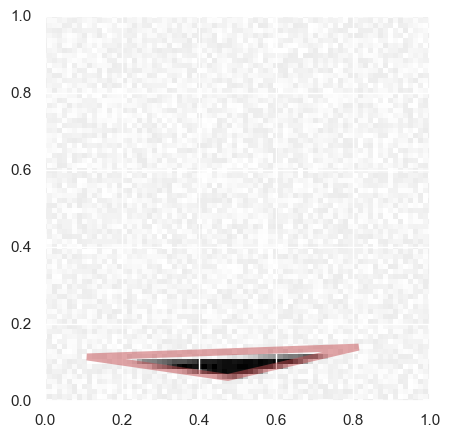

In [51]:
# Visualize a training sample
visualize_prediction(X_train_reg[3], Y_train_reg[3])

In [52]:
# Sort the abscises in acending order to provide additional information to the algorith
# the modification was made directly on the "Getting Started" part

In [53]:
# Build the convolutional deep network
# BatchNormalization: normalize input layer by adjusting and scaling the activations to speed up learning
model_reg = Sequential()
model_reg.add(BatchNormalization(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))

In [54]:
# init = “he_normal”: find a good variance for the distribution for the initial parameters
model_reg.add(Conv2D(24,5,5, border_mode = "same",init="he_normal", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), dim_ordering= "tf", activation="relu"))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(100, 100,..., activation="relu", padding="same", data_format="channels_last", kernel_initializer="he_normal")`
  


In [55]:
# strides = (2,2) step size of the kernel for downsampling the image
# border_mode = valid: get a smaller output than the input

model_reg.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="valid"))
model_reg.add(Conv2D(36, 5, 5, activation = "relu"))
model_reg.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="valid"))
model_reg.add(Conv2D(48, 5, 5,activation="relu"))
model_reg.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="valid"))
model_reg.add(Conv2D(64, 3, 3,activation="relu"))
model_reg.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="valid"))
model_reg.add(Conv2D(64, 3, 3,activation = "relu"))
model_reg.add(GlobalAveragePooling2D())
model_reg.add(Dense(500, activation="relu"))
model_reg.add(Dense(90, activation="relu"))
model_reg.add(Dense(6))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")`
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu")`
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")`
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu")`
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")`
  
/anaconda3/lib/python3.6

In [56]:
# optimizer “rmsprop” : to resolve Adagrad’s radically diminishing learning rates
model_reg.compile(optimizer='rmsprop', loss='mse')

In [57]:
# reshape the input for convolution layer
n_rows_reg = X_train_reg.shape[0]
X_train_reg = X_train_reg.reshape(n_rows_reg,IMAGE_SIZE,IMAGE_SIZE,1)

In [58]:
# Fit the convolutional (not-to-)deep network
EarlyStopping_monitor = EarlyStopping(patience=2)
model_reg.fit(X_train_reg, Y_train_reg, batch_size=32, epochs=15,callbacks=[EarlyStopping_monitor])

Epoch 1/15
2000/2000 [==============================] - 61s 30ms/step - loss: 0.1225
Epoch 2/15


/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2000/2000 [==============================] - 57s 28ms/step - loss: 0.0487
Epoch 3/15
2000/2000 [==============================] - 55s 27ms/step - loss: 0.0351
Epoch 4/15
2000/2000 [==============================] - 58s 29ms/step - loss: 0.0265
Epoch 5/15
2000/2000 [==============================] - 63s 31ms/step - loss: 0.0201
Epoch 6/15
2000/2000 [==============================] - 57s 29ms/step - loss: 0.0172
Epoch 7/15
2000/2000 [==============================] - 70s 35ms/step - loss: 0.0149
Epoch 8/15
2000/2000 [==============================] - 57s 29ms/step - loss: 0.0133
Epoch 9/15
2000/2000 [==============================] - 55s 28ms/step - loss: 0.0122
Epoch 10/15
2000/2000 [==============================] - 55s 27ms/step - loss: 0.0109
Epoch 11/15
2000/2000 [==============================] - 52s 26ms/step - loss: 0.0099
Epoch 12/15
2000/2000 [==============================] - 52s 26ms/step - loss: 0.0095
Epoch 13/15
2000/2000 [==============================] - 52s 26ms/step - 

In [59]:
# Build a test dataset
[X_test_reg, Y_test_reg] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [60]:
# Reshape the test input for convolutional network
X_test_reg = X_test_reg.reshape(300,IMAGE_SIZE,IMAGE_SIZE,1)

In [61]:
# Evaluate the model
model_reg.evaluate(X_test_reg, Y_test_reg)

300/300 [==============================] - 5s 16ms/step


0.014102279009918372

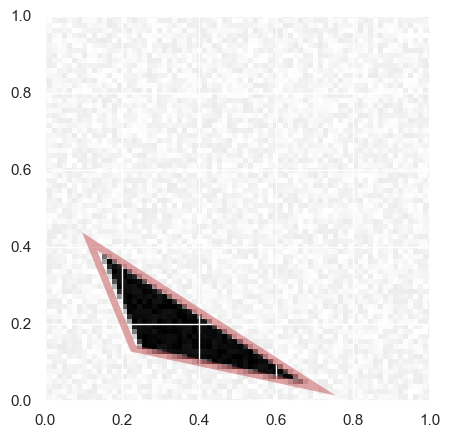

In [64]:
# Plot a solution
visualize_prediction(X_test_reg[1], Y_test_reg[1])

Conclusion:
Whithout the modification of the dataset (by ordering), it was difficult to get a good accuracy. It would have required much more computing power to get a good prediction.

On the opposite, when using the ordering of the dataset, we can see that the vertices are well predicted by the neural network at the end. 

## 7. Image Denoising

Description:

I modified the initial functions to generate pair of images and add noise. The The noise for the input images corresponds to a figure randomly selected from 0 to 100.

Firstly, I tried to implement the real U-net model but I realized that it would be too heavy to compute on my computer (more than 3,5 million parameters...)

Secondly, I reduced the number of nodes in each layer of my U-net network to be able to compute it. I divided the U-net network in 3 parts: the contracting path, the bottle neck and the expanding path. In addition to Conv2D and Maxpool Layers, I used the upsampling and concatenate layers to reconstruct progressively the original image size.



In [67]:
# Change the Image size
IMAGE_SIZE = 64

In [68]:
# Set the noise level randomly drawn from [0:100]
random_noise = 100

# Modify the generate_a_* functions to generate pairs of images (noise + no noise)
# Create a new function to build the dataset 

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle_noise(free_location=False):
    figsize = 0.64   
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    imdata1= generate_a_drawing(figsize, U, V)
    imdata = generate_a_drawing(figsize, U, V, noise = np.random.randint(0,random_noise) )
    return imdata,imdata1


def generate_a_disk_noise(free_location=False):
    figsize = 0.64
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    imdata1= generate_a_drawing(figsize, U, V)
    imdata = generate_a_drawing(figsize, U, V, noise = np.random.randint(0,random_noise) )
    return imdata,imdata1

def generate_a_triangle_noise(free_location=False):
    figsize = 0.64
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata1= generate_a_drawing(figsize, U, V)
    imdata = generate_a_drawing(figsize, U, V, noise = np.random.randint(0,random_noise) )
    return imdata,imdata1

def generate_dataset_noise(nb_samples, free_location=False):
    # Getting im_size:
    im_size = IMAGE_SIZE*IMAGE_SIZE
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            u,v = generate_a_rectangle_noise(free_location)
            X[i] = u
            Y[i] = v
        elif category == 1:
            u,v = generate_a_disk_noise(free_location)
            X[i] = u
            Y[i] = v
        else:
            u,v = generate_a_triangle_noise(free_location)
            X[i] = u
            Y[i] = v
    return [X, Y]

In [93]:
# Define size of the sample
n_sample = 5000
# Create a dataset with pair of images 
[X_train_noise, Y_train_noise] = generate_dataset_noise(n_sample,True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

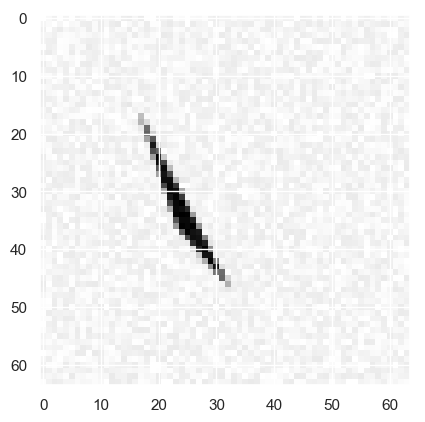

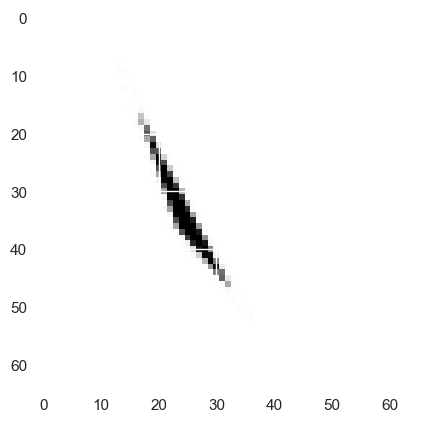

In [96]:
# Plot an example 
fig = plt.figure()
a=fig.add_subplot(1,1,1)
plt.imshow(X_train_noise[25].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
a=fig.add_subplot(2,1,1)
plt.imshow(Y_train_noise[25].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

In [97]:
# reshape the input and output for convolution layer
n_rows_noise = X_train_noise.shape[0]
X_train_noise = X_train_noise.reshape(n_sample,IMAGE_SIZE,IMAGE_SIZE,1)
Y_train_noise = Y_train_noise.reshape(n_sample,IMAGE_SIZE,IMAGE_SIZE,1)


### Real-size U-net achitecture (not run)

In [ ]:
# Build the real U-net algorithm but not run because of the high number of parameters to optimize

In [70]:
# Build a U-net architecture
model_noise = Sequential()
model_noise.add(BatchNormalization(input_shape=(IMAGE_SIZE,IMAGE_SIZE, 1)))

# define input
inputs = Input(shape = (IMAGE_SIZE,IMAGE_SIZE, 1) )

In [71]:
# contracting path
conv1a = Conv2D(64,3,activation="relu",padding='same')(inputs) 
conv1b = Conv2D(64,3,activation="relu",padding='same')(conv1a) 
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1b)

conv2a = Conv2D(128,3,activation="relu",padding='same')(pool1) 
conv2b = Conv2D(128,3,activation="relu",padding='same')(conv2a) 
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2b)

conv3a = Conv2D(256,3,activation="relu",padding='same')(pool2) 
conv3b = Conv2D(256,3,activation="relu",padding='same')(conv3a) 
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3b)

conv4a = Conv2D(512,3,activation="relu",padding='same')(pool3)
conv4b = Conv2D(512,3,activation="relu",padding='same')(conv4a)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4b)

In [72]:
# bottleneck
conv5a = Conv2D(1024,3,activation="relu",padding='same')(pool4)
conv5b = Conv2D(1024,3,activation="relu",padding='same')(conv5a)


In [73]:
# expanding path
up6 = UpSampling2D(size = (2,2)) (conv5b)
merge6 = Concatenate(axis=3)([conv4b,up6])
conv6b = Conv2D(512,3,activation="relu",padding='same')(merge6)
conv6c = Conv2D(512,3,activation="relu",padding='same')(conv6b)

up7 = UpSampling2D(size = (2,2)) (conv6c)
merge7 = Concatenate(axis=3)([conv3b,up7])
conv7b = Conv2D(256,3,activation="relu",padding='same')(merge7)
conv7c = Conv2D(256,3,activation="relu",padding='same')(conv7b)

up8 = UpSampling2D(size = (2,2)) (conv7c)
merge8 = Concatenate(axis=3)([conv2b,up8])
conv8b = Conv2D(128,3,activation="relu",padding='same')(merge8)
conv8c = Conv2D(128,3,activation="relu",padding='same')(conv8b)

up9 = UpSampling2D(size = (2,2)) (conv8c)
merge9 = Concatenate(axis=3)([conv1b,up9])
conv9b = Conv2D(64,3,activation="relu",padding='same')(merge9)
conv9c = Conv2D(64,3,activation="relu",padding='same')(conv9b)

# define output
conv10 = Conv2D(1,1,activation="sigmoid")(conv9c)

In [74]:
# Compile the model
model_noise = Model(inputs = [inputs], outputs = [conv10])
model_noise.compile(optimizer='adam', loss='mse')

In [75]:
# Too many parameters (31 millions..)... need to reduce the number
model_noise.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 64, 64, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 64, 64, 64)   36928       conv2d_16[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 32, 32, 64)   0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 

### More realistic Unet model (with less parameters)

In [98]:
# build a more humble Unet model

# Build a U-net architecture
model_noise_2 = Sequential()
model_noise_2.add(BatchNormalization(input_shape=(IMAGE_SIZE,IMAGE_SIZE, 1)))

# define input
inputs_2 = Input(shape = (IMAGE_SIZE,IMAGE_SIZE,1))

In [99]:
# contracting path
conv1a = Conv2D(8,3,activation="relu",padding='same')(inputs_2) 
conv1b = Conv2D(8,3,activation="relu",padding='same')(conv1a) 
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1b)

conv2a = Conv2D(16,3,activation="relu",padding='same')(pool1) 
conv2b = Conv2D(16,3,activation="relu",padding='same')(conv2a) 
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2b)

conv3a = Conv2D(32,3,activation="relu",padding='same')(pool2) 
conv3b = Conv2D(32,3,activation="relu",padding='same')(conv3a) 
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3b)

conv4a = Conv2D(64,3,activation="relu",padding='same')(pool3)
conv4b = Conv2D(64,3,activation="relu",padding='same')(conv4a)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4b)

# bottleneck
conv5a = Conv2D(128,3,activation="relu",padding='same')(pool4)
conv5b = Conv2D(128,3,activation="relu",padding='same')(conv5a)

# expanding path
up6 = UpSampling2D(size = (2,2)) (conv5b)
merge6 = Concatenate(axis=3)([conv4b,up6])
conv6b = Conv2D(64,3,activation="relu",padding='same')(merge6)
conv6c = Conv2D(64,3,activation="relu",padding='same')(conv6b)

up7 = UpSampling2D(size = (2,2)) (conv6c)
merge7 = Concatenate(axis=3)([conv3b,up7])
conv7b = Conv2D(32,3,activation="relu",padding='same')(merge7)
conv7c = Conv2D(32,3,activation="relu",padding='same')(conv7b)

up8 = UpSampling2D(size = (2,2)) (conv7c)
merge8 = Concatenate(axis=3)([conv2b,up8])
conv8b = Conv2D(16,3,activation="relu",padding='same')(merge8)
conv8c = Conv2D(16,3,activation="relu",padding='same')(conv8b)

up9 = UpSampling2D(size = (2,2)) (conv8c)
merge9 = Concatenate(axis=3)([conv1b,up9])
conv9b = Conv2D(8,3,activation="relu",padding='same')(merge9)
conv9c = Conv2D(8,3,activation="relu",padding='same')(conv9b)
# define output
conv10_2 = Conv2D(1,1)(conv9c)

In [100]:
# Compile the model
model_noise_2 = Model(inputs = [inputs_2], outputs= [conv10_2])
model_noise_2.compile(optimizer='adam', loss='mse')

In [102]:
# Fit the convolutional deep network
EarlyStopping_monitor = EarlyStopping(patience=3)
model_noise_2.fit(X_train_noise, Y_train_noise, batch_size=32, epochs=50)

Epoch 1/20
5000/5000 [==============================] - 119s 24ms/step - loss: 21.4737
Epoch 2/20
5000/5000 [==============================] - 115s 23ms/step - loss: 17.8521
Epoch 3/20
5000/5000 [==============================] - 113s 23ms/step - loss: 19.6599
Epoch 4/20
5000/5000 [==============================] - 115s 23ms/step - loss: 22.7176
Epoch 5/20
5000/5000 [==============================] - 114s 23ms/step - loss: 16.9600
Epoch 6/20
5000/5000 [==============================] - 112s 22ms/step - loss: 16.6555
Epoch 7/20
5000/5000 [==============================] - 112s 22ms/step - loss: 16.0676
Epoch 8/20
5000/5000 [==============================] - 110s 22ms/step - loss: 17.6092
Epoch 9/20
5000/5000 [==============================] - 1668s 334ms/step - loss: 15.8211
Epoch 10/20
5000/5000 [==============================] - 130s 26ms/step - loss: 15.2327
Epoch 11/20
5000/5000 [==============================] - 123s 25ms/step - loss: 15.2774
Epoch 12/20
5000/5000 [================

In [103]:
# Generate a test dataset
[X_test_noise, Y_test_noise] = generate_dataset_noise(300,True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [106]:
# reshape the input and output for convolution layer
X_test_noise = X_test_noise.reshape(300,IMAGE_SIZE,IMAGE_SIZE,1)
Y_test_noise = Y_test_noise.reshape(300,IMAGE_SIZE,IMAGE_SIZE,1)

In [107]:
# Get the prediction from our convolution model
Y_predict_noise = model_noise_2.predict(X_test_noise)

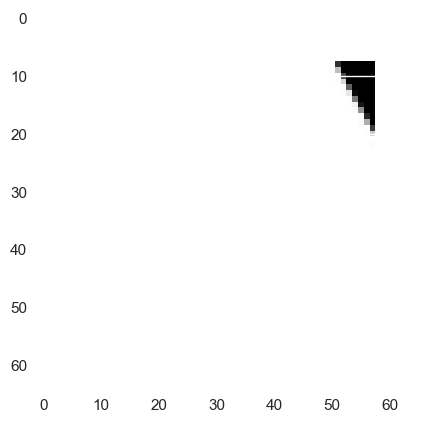

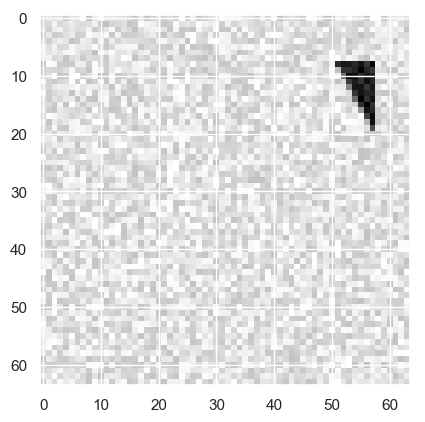

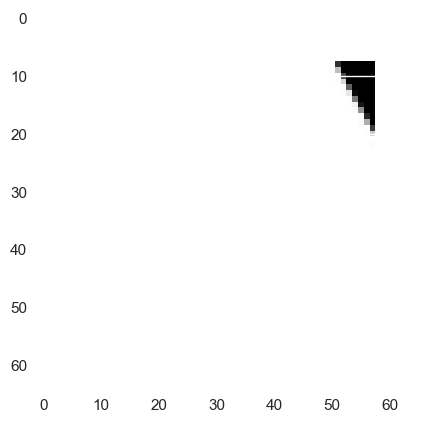

In [117]:
# Plot an example 
fig = plt.figure()
a=fig.add_subplot(1,1,1)
plt.imshow(Y_test_noise[16].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
a=fig.add_subplot(2,1,1)
plt.imshow(X_test_noise[16].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
a=fig.add_subplot(3,1,1)
plt.imshow(Y_test_noise[16].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

Conclusion:

The "more realistic" U-net works well as it is shown by the above prediction. The model manages to get rid of a great part of the noise.